In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import sklearn.pipeline as skpipe

In [46]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
ff_factors = ff_factors.loc[ff_factors.index >= 196311]
ff_factors = ff_factors.loc[ff_factors.index <= 201712]
portfolio_panel = pd.read_csv('25_Portfolios_5x5.CSV', skiprows=15, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
portfolio_panel = portfolio_panel.loc[portfolio_panel.index >= 196311]
portfolio_panel = portfolio_panel.loc[portfolio_panel.index <= 201712]
portfolio370_panel = pd.read_csv('370portfolios.csv', skiprows=1, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)


In [48]:
ff_factor_panel = ff_factors.to_numpy()
portfolio_return_panel = portfolio_panel.to_numpy() / 100
portfolio370_return_panel = portfolio370_panel.to_numpy()

In [55]:
panel_evals, _ = np.linalg.eigh(portfolio_return_panel.dot(portfolio_return_panel.T))
panel_evals = panel_evals[::-1]

panel370_evals, _ = np.linalg.eigh(portfolio370_return_panel.dot(portfolio370_return_panel.T))
panel370_evals = panel370_evals[::-1]

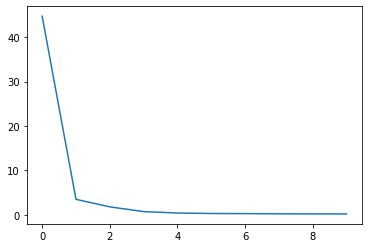

In [59]:
plt.plot(panel_evals[:10])

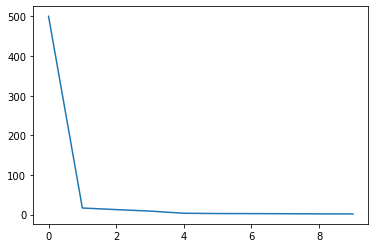

In [60]:
plt.plot(panel370_evals[:10])

In [121]:
def ic_1(N,T):
    NT = N*T
    N_plus_T = N+T
    # Make information critea penalties

    return np.log(NT/N_plus_T) * N_plus_T/NT

def l2_loss(N,T,data_panel, pred_data):
    return (1/(N*T))*np.sum(np.square(data_panel - pred_data))

def fit_bai_ng(data_panel, K):
    pipe = skpipe.Pipeline([('Standardize', skp.StandardScaler(with_mean=True, with_std=True)),
                            ('Factors', skd.TruncatedSVD(K, algorithm='arpack'))])

    F = pipe.fit_transform(data_panel)
    lmbda = np.linalg.lstsq(F,data_panel, rcond=None)[0]
#     data_hat_last = pipe.inverse_transform(F)
    data_hat_last = F.dot(lmbda)
#     assert np.allclose(data_hat_last, F.dot(lmbda)), np.max(np.abs(data_hat_last - F.dot(lmbda)))
    return F, lmbda, data_hat_last

def bai_ng_ev_criterion(data_panel, ic_func, max_evs=10):
    T, N = data_panel.shape
    penalized_function_resuls = []
    for i in range(1, max_evs + 1):
        F, lmbda, pred_panel = fit_bai_ng(data_panel, i)
        penalized_function_resuls.append(np.log(l2_loss(N,T,data_panel, pred_panel)) + i*ic_func(N,T))
    return penalized_function_resuls
    
def fit_rp_pca(data_panel, K, gamma):
    T, N = data_panel.shape
#     std_pipe = skpipe.Pipeline([('Standardize', skp.StandardScaler(with_mean=True, with_std=True))])
    fit_pipe = skpipe.Pipeline([('loadings', skd.TruncatedSVD(K, algorithm='arpack'))])
    
    r_bar = np.mean(data_panel, axis=0, keepdims=True)
    objective  = (1/(N*T))*data_panel.T.dot(data_panel) + (gamma/T)*r_bar.T.dot(r_bar)
    
    lmbda = fit_pipe.fit_transform(objective)
    print(lmbda.shape, data_panel.shape)
    F =  np.linalg.lstsq(lmbda, data_panel.T, rcond=None)
    
    return lmbda, F
    

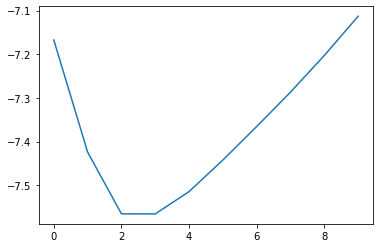

In [111]:
by_factor_ic = bai_ng_ev_criterion(portfolio_return_panel, ic_1)
plt.plot(by_factor_ic)    

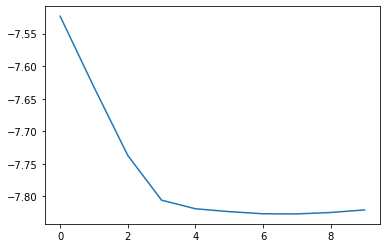

In [112]:
by_factor_ic = bai_ng_ev_criterion(portfolio370_return_panel, ic_1)
plt.plot(by_factor_ic)